In [111]:
#libraries
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd

In [112]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

In [113]:
#Analysis parameters
# #20000 human genes, each human gene is a linkage block
linkageblocksperchorm =200.0
chromosomenumber=23.0
totallinkageblocks=linkageblocksperchorm*chromosomenumber

humanUd = [2.0, 10.0]
Kimetalsd=0.009
Boykoetalsd=0.029

log10humanUd = np.log10(humanUd)
Udcolor = '#009E73'
log10Kim = np.log10(Kimetalsd)
Kimcolor = '#E69F00'
log10Boyko = np.log10(Boykoetalsd)
Boykocolor = '#56B4E9'

N1=200
N1color = '#F0E442'
N2=2000
N2color = '#CC79A7'
N3=20000
N3color = '#D55E00'

deterministiccolor = 'black'


In [114]:
#simulation parameters
Udlabel = np.array(["0.5", "1", "2", "10"])
Udnum = Udlabel.astype(float)

simulated_vx = np.zeros(len(Udlabel))
Nsim=1000.0
burnin = np.array([1243.0, 1052.0, 1003.0, 848.0])
totalGen = 10000.0
Recordedgenerations = totalGen-burnin

foldernames = "data/datafor_relative_tskitstatus_ON_BURNIN_fixationcalc_OFF_Sb_1.0000_deldist_exponential_bendist_exponential_mub_0.0000_chromnum_23_N0_1000_mud_" + Udlabel + "_L_200_seed_24_Sd_0.029000/"

In [149]:
#function returns Ne as in Matheson and Masel 2024. 
#r=2 per chromosome, two recombination events for chromosome arm
#Made a fix to his theory Ne/N = exp(4*Ud*sh). A 4 insted of their 8
def calculate_Ne(Ud, meansd, totallinkageblocks, chromosomenumber, N):
  Ne = N*np.exp(-4.0*Ud*(1.0-(1.0/totallinkageblocks))*(np.abs(meansd)))*np.exp(-Ud/(chromosomenumber*2.0))
  return Ne

#Calculates the product of DFE and Probability of fixation
def PfixDFE(sd, meansd, Ne):
  Pfix = (1.0-np.exp(-2.0*(sd), dtype=np.float128))/(1.0-np.exp(-4.0*Ne*(sd), dtype=np.float128))
  #DFE is calculated using simulation's sd. The sd here equals  sd=np.log(1.0-simulation's sd)
  #Then simulation's sd = 1-e^(sd)
  DFEsdterm = np.abs(1.0-np.exp(sd))
  DFEmeansdterm = np.abs(1.0-np.exp(meansd))
  DFE = np.exp(-DFEsdterm/DFEmeansdterm, dtype=np.float128)/DFEmeansdterm
  return Pfix*DFE

#Calculates the integral of Pfix*DFE
def calculate_PfixDFE(meansd, Ne):
  result = integrate.quad(PfixDFE, -1, 0, args=(meansd, Ne))
  return abs(result[0])

#Callin this function gives the rate of mutation accumulation per generation given single locus theory
def calculate_stochastic_accumulation(Ud, meansd, totallinkageblocks, chromosomenumber, N):
  Mcandlish_meansd = np.log(1.0-meansd)
  Ne = calculate_Ne(Ud, meansd, totallinkageblocks, chromosomenumber, N)
  stochastic_accumulation = Ud*Ne*calculate_PfixDFE(Mcandlish_meansd, Ne)
  return stochastic_accumulation

#Calculates the constant in the frequency equation given by Wright 1937
#mu_d is the per site mutation rate
#Ne is the effective breeding population size
def frequency_constant(q, meansd, Ne, mu_d):
  meanfitnessterm = (1.0 - 2.0*meansd*q*(1.0-q)-(meansd/2.0)*q**2.0)**(2*Ne)
  freqterms = q**(4.0 * Ne * mu_d - 1.0)/(1.0 - q)
  result = meanfitnessterm*freqterms
  return result

def expected_frequency(q, meansd, Ne, mu_d):
  meanfitnessterm = (1.0 - 2.0*meansd*q*(1.0-q)-(meansd/2.0)*q**2.0)**(2*Ne)
  freqterms = q**(4.0 * Ne * mu_d - 1.0)/(1.0 - q)
  result = q*meanfitnessterm*freqterms
  return result

def calculate_expected_frequency(meansd, Ud, totallinkageblocks, chromosomenumber, N):
  Mcandlish_meansd = np.log(1.0-meansd)
  Ne = calculate_Ne(Ud, meansd, totallinkageblocks, chromosomenumber, N)
  mu_d = Ud/totallinkageblocks
  freqconstant = integrate.quad(frequency_constant, 1e-10, 1 - 1e-10, epsabs=1e-10, epsrel=1e-10, args=(meansd, Ne, mu_d))
  numeratorexp = integrate.quad(expected_frequency, 1e-10, 1 - 1e-10, epsabs=1e-10, epsrel=1e-10, args=(meansd, Ne, mu_d))
  result = numeratorexp[0]/freqconstant[0]
  return result

0.6010202956696944
0.8565880682356838
1.2313749039751887
29.415696165148898


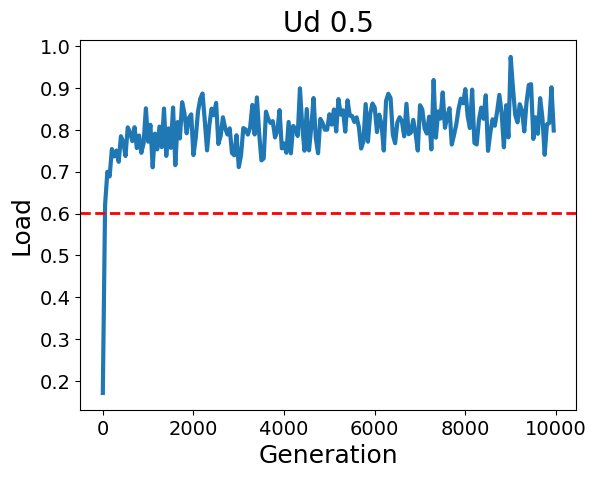

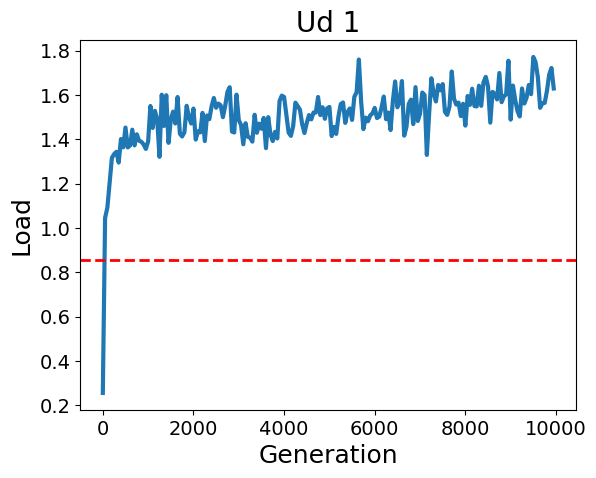

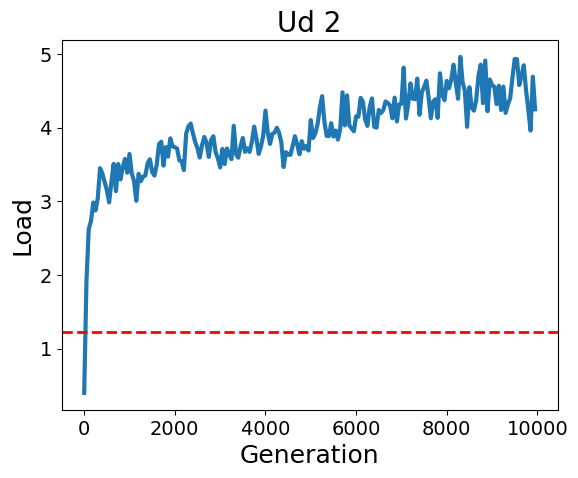

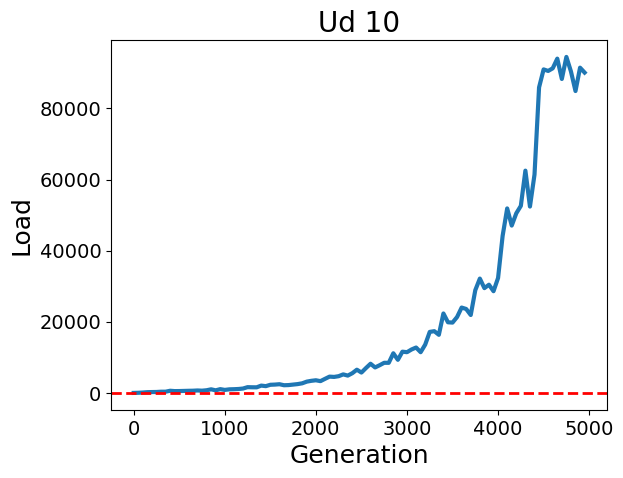

In [150]:
for i in range(len(Udlabel)):
    fitnessdatafile = "rawdataforNxtimesteps10000popsize1000mutrate" + Udlabel[i] + "chromsize200chromnum23benmutrate0.0000Sb1.0000.txt"
    list_fitnessdata = pd.read_csv(foldernames[i]+fitnessdatafile)

    sampleeach = 50
    averageBirthRate = list_fitnessdata.loc[:, 'Sum.of.wis']/Nsim
    averageBirthRate = averageBirthRate[::sampleeach]
    variancelogBirthRate = list_fitnessdata.loc[:, 'Variance.in.log.fitness']
    variancelogBirthRate = variancelogBirthRate[::sampleeach]

    Load = 4.9*np.sqrt(variancelogBirthRate/averageBirthRate)
    Generation = list_fitnessdata.loc[:, 'Nxtimesteps']
    Generation = Generation[::sampleeach]

    list_fitnessdata

    Mcandlish_meansd = np.log(1.0-Boykoetalsd)
    meansd = Boykoetalsd
    mean_segregatingmutations_persite = calculate_expected_frequency(Boykoetalsd, Udnum[i], totallinkageblocks, chromosomenumber, Nsim)
    mean_segregatingmutations = mean_segregatingmutations_persite*totallinkageblocks
    expterm = mean_segregatingmutations*(Boykoetalsd**2.0)
    Theory_Load = 4.9*np.sqrt(np.exp(expterm)-1.0)
    print(Theory_Load)

    plt.figure() 
    plt.plot(Generation, Load)
    plt.xlabel(r"Generation")
    plt.ylabel(r"Load")
    plt.title("Ud " + Udlabel[i])
    plt.axhline(y=Theory_Load, color='r', linestyle='--', linewidth=2)
    plt.savefig("graphs/Load_Ud_" + Udlabel[i] + ".png")

/tmp/ipykernel_7806/1886773571.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1.0-np.exp(-2.0*(sd), dtype=np.float128))/(1.0-np.exp(-4.0*Ne*(sd), dtype=np.float128))


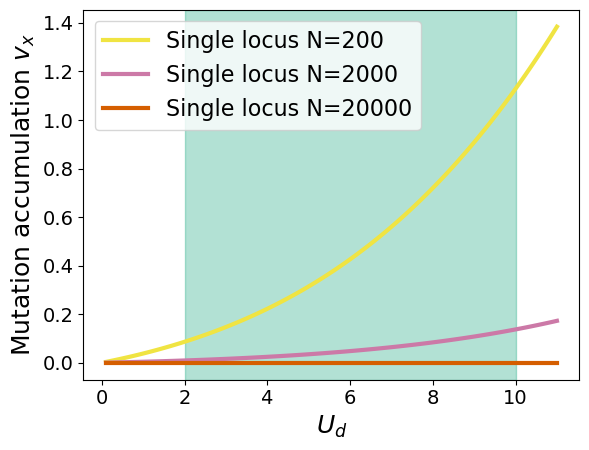

In [117]:
#accumulation rate for Boyko et al 
Ud = np.linspace(start=0.1, stop=11, num=100)
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)

stochastic_acc_N1 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Single locus N='
Boykoplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.legend()
plt.xlabel(r"$U_{d}$")
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('graphs/Boykosd_mutationaccumulation.png', dpi=300)

[0.00822199 0.01374609 0.03578971 0.29031906]


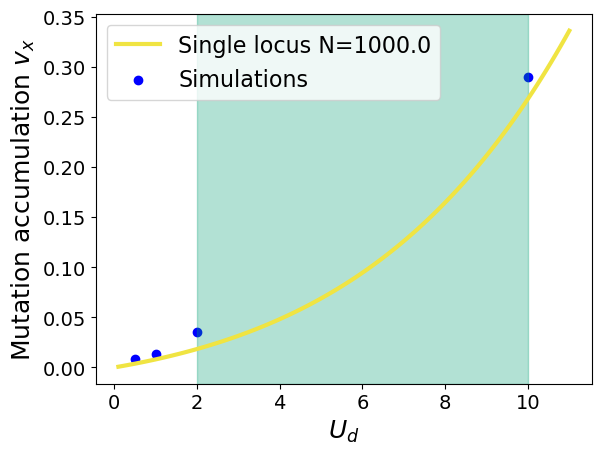

In [118]:
#acummulation rate from equations and simulation data
mutationsfile = "fixed_mut.txt"
for i in range(len(Udlabel)):
    list_simulatedfix = pd.read_csv(foldernames[i]+mutationsfile)
    num_simulatedfix = float(len(list_simulatedfix))
    simulated_vx[i] = num_simulatedfix/Recordedgenerations[i]

print(simulated_vx)
#Plotting simulations alongside Boyko 
stochastic_acc_Nsim = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, Nsim)

stochastic_label = 'Single locus N='
simulations_label = 'Simulations'
plt.figure()
plt.plot(Ud, stochastic_acc_Nsim, label = f"{stochastic_label}{Nsim}", color = N1color)
plt.scatter(Udnum, simulated_vx, label = simulations_label, color='blue', marker='o')
plt.legend()
plt.xlabel(r"$U_{d}$")
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('graphs/Boykosd_vs_simulated.png', dpi=300)

/tmp/ipykernel_7806/1886773571.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1.0-np.exp(-2.0*(sd), dtype=np.float128))/(1.0-np.exp(-4.0*Ne*(sd), dtype=np.float128))


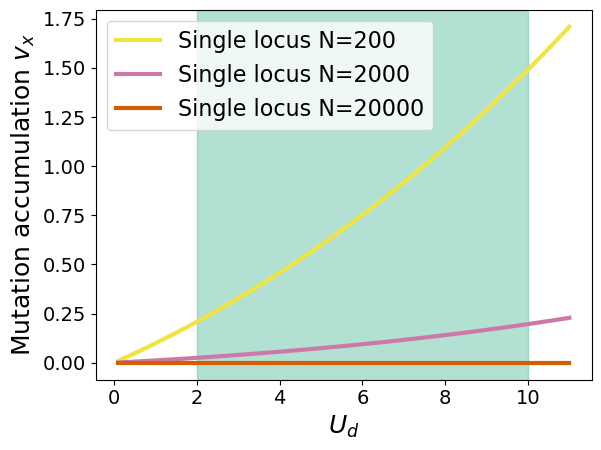

In [119]:
#accumulation contribution for Kim et al 
stochastic_acc_N1 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Single locus N='
Boykoplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.legend()
plt.xlabel(r"$U_{d}$")
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('graphs/Kimsd_mutationaccumulation.png', dpi=300)